<ipython-input-1-7cd546a151e7>:16: DtypeWarning: Columns (7,9,10,11,12,13,14,22,33) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('/content/cleaned_wildfire_dataset.csv')



Generating Correlation Matrix...


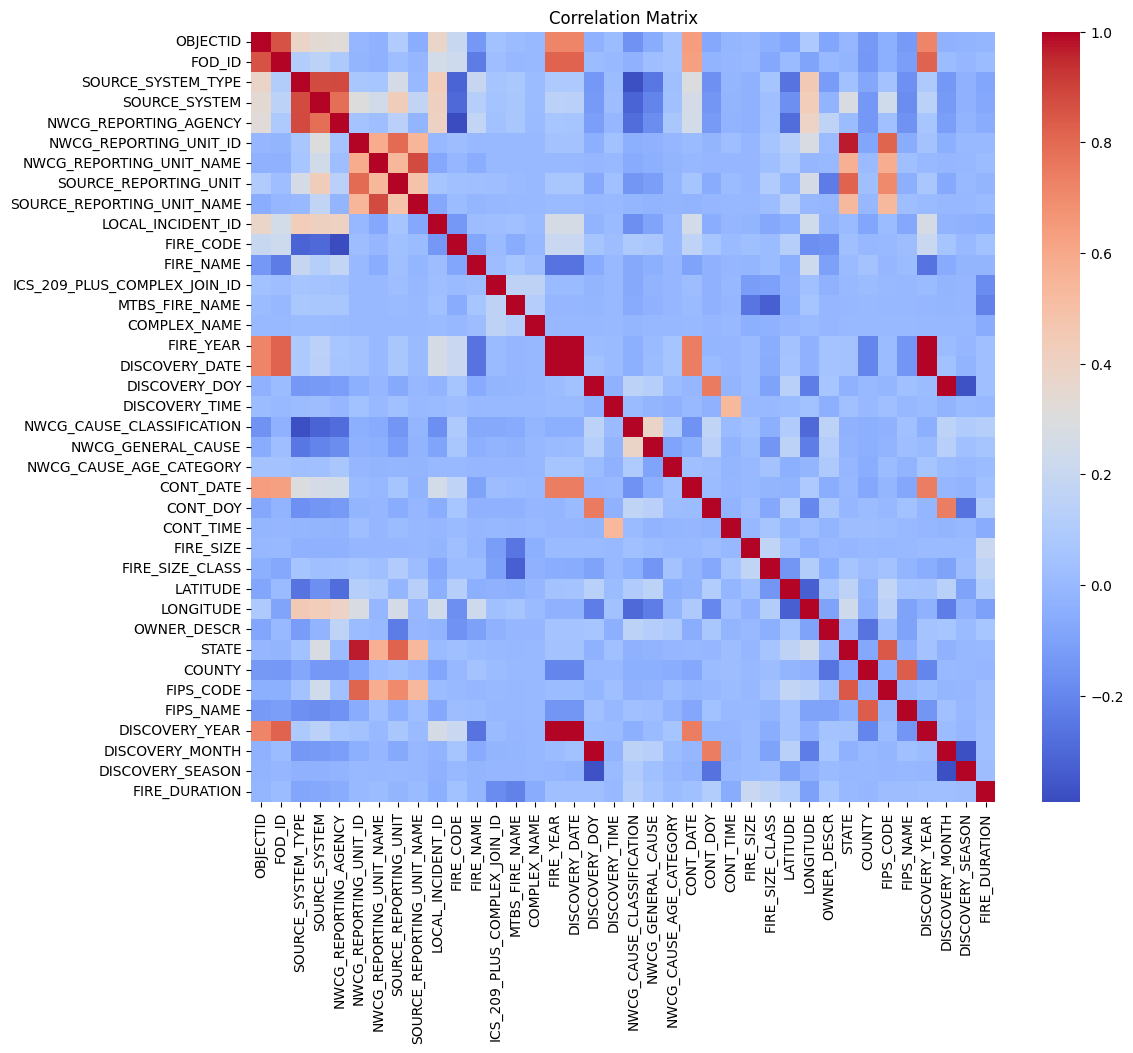


Training Random Forest...
Validation Accuracy for Random Forest: 0.9907
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       478
           1       1.00      0.99      1.00       478
           2       0.99      0.99      0.99       478
           3       0.98      1.00      0.99       479
           4       0.98      0.99      0.98       478
           5       0.98      0.98      0.98       478
           6       1.00      0.99      0.99       479

    accuracy                           0.99      3348
   macro avg       0.99      0.99      0.99      3348
weighted avg       0.99      0.99      0.99      3348

Test Accuracy for Random Forest: 0.9919
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       478
           1       1.00      1.00      1.00       478
           2       0.99      1.00      0.99       479
           3       0.99      1.00      0.99       478
           4       

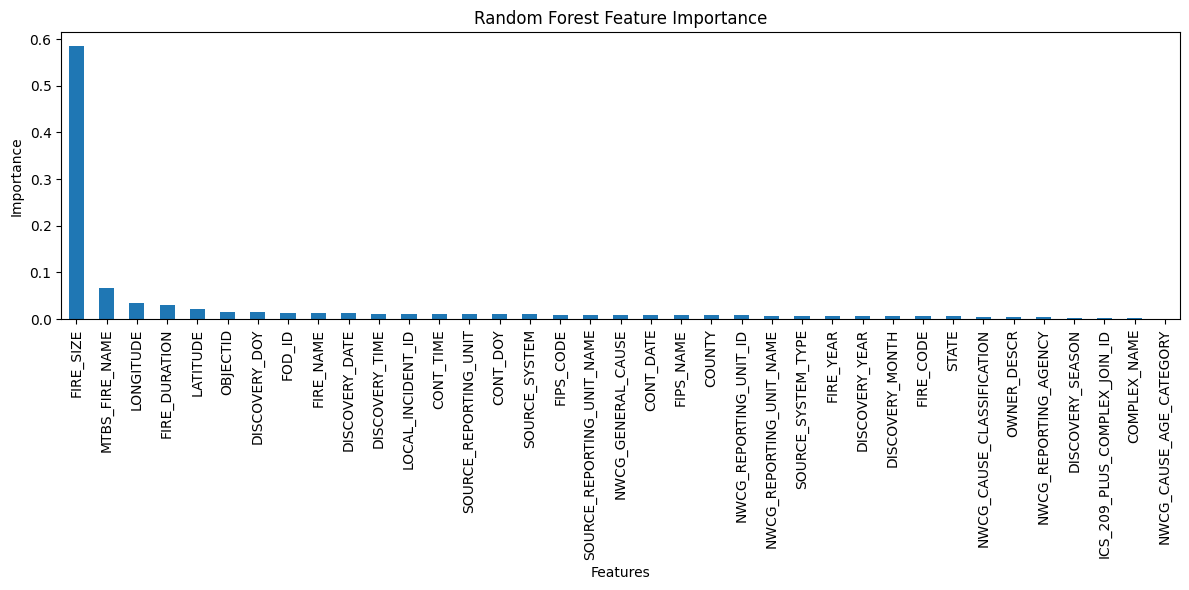


Training SVM...
Validation Accuracy for SVM: 0.7213
              precision    recall  f1-score   support

           0       0.53      0.64      0.58       478
           1       0.38      0.30      0.33       478
           2       0.44      0.54      0.49       478
           3       0.82      0.72      0.77       479
           4       0.97      0.88      0.92       478
           5       0.97      0.98      0.98       478
           6       0.99      1.00      0.99       479

    accuracy                           0.72      3348
   macro avg       0.73      0.72      0.72      3348
weighted avg       0.73      0.72      0.72      3348

Test Accuracy for SVM: 0.7301
              precision    recall  f1-score   support

           0       0.54      0.65      0.59       478
           1       0.40      0.36      0.38       478
           2       0.46      0.53      0.49       479
           3       0.82      0.69      0.75       478
           4       0.98      0.91      0.94      

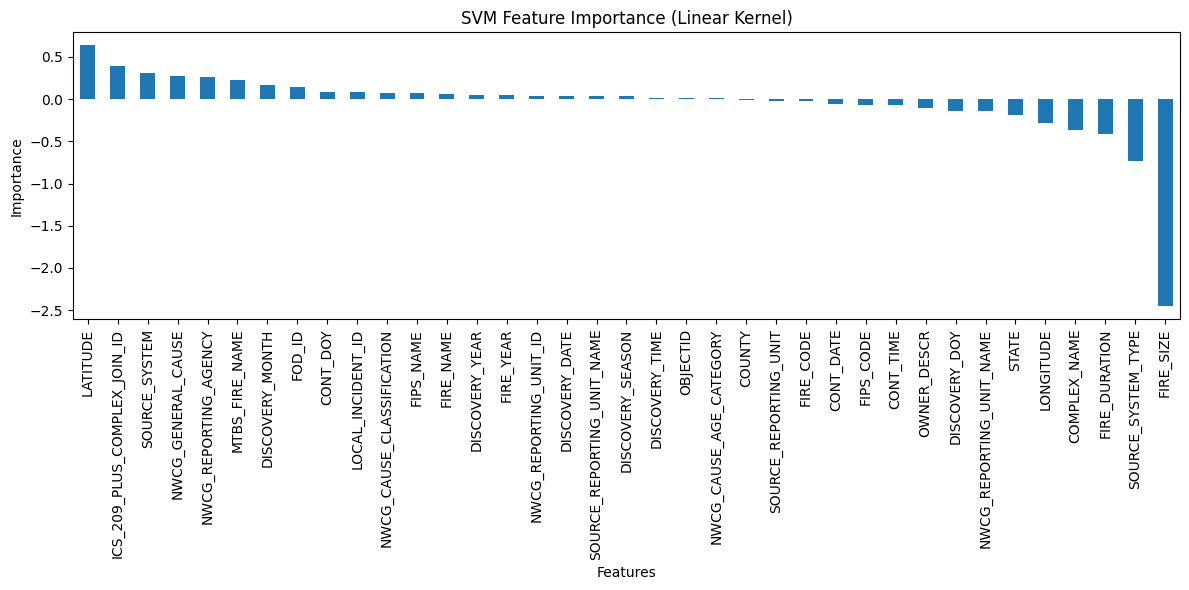


Training XGBoost...
Validation Accuracy for XGBoost: 0.9994
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       478
           1       1.00      1.00      1.00       478
           2       1.00      1.00      1.00       478
           3       1.00      1.00      1.00       479
           4       1.00      1.00      1.00       478
           5       1.00      1.00      1.00       478
           6       1.00      1.00      1.00       479

    accuracy                           1.00      3348
   macro avg       1.00      1.00      1.00      3348
weighted avg       1.00      1.00      1.00      3348

Test Accuracy for XGBoost: 0.9982
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       478
           1       0.99      1.00      0.99       478
           2       1.00      1.00      1.00       479
           3       1.00      1.00      1.00       478
           4       1.00      1.00    

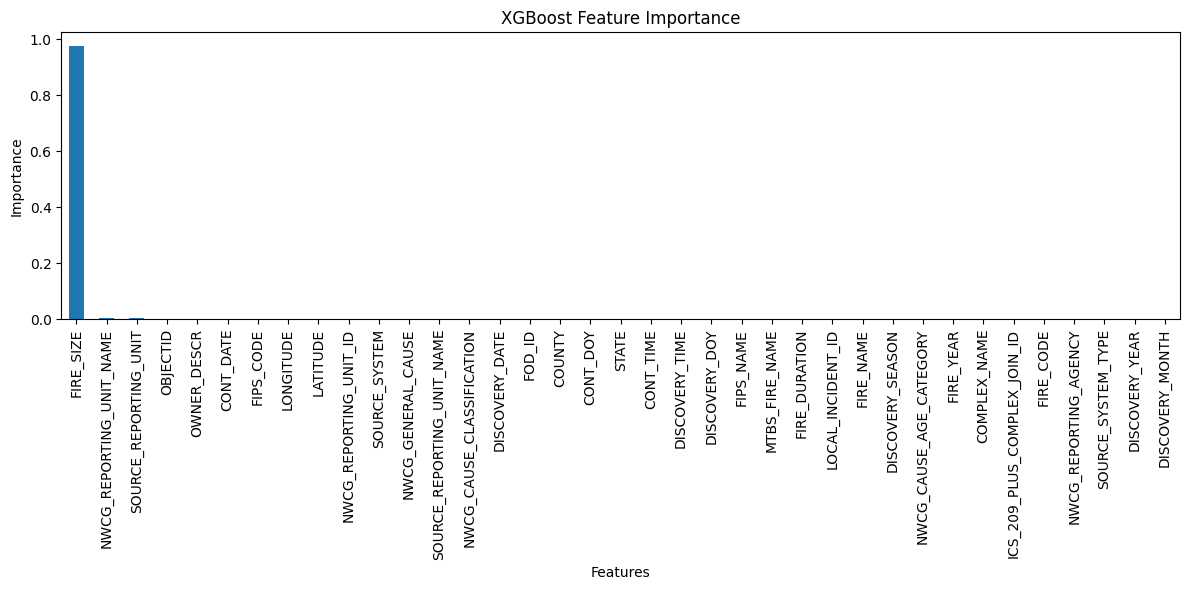


Training Gaussian Naive Bayes...
Validation Accuracy for Gaussian Naive Bayes: 0.7587
              precision    recall  f1-score   support

           0       0.57      0.99      0.72       478
           1       0.98      0.19      0.32       478
           2       0.82      0.95      0.88       478
           3       0.82      0.78      0.80       479
           4       0.85      0.74      0.79       478
           5       0.83      0.75      0.79       478
           6       0.78      0.91      0.84       479

    accuracy                           0.76      3348
   macro avg       0.81      0.76      0.73      3348
weighted avg       0.81      0.76      0.73      3348

Test Accuracy for Gaussian Naive Bayes: 0.7713
              precision    recall  f1-score   support

           0       0.58      0.99      0.73       478
           1       0.94      0.24      0.39       478
           2       0.81      0.94      0.87       479
           3       0.82      0.75      0.79       47

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # For saving the models
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the dataset (replace 'dataset.csv' with your actual file)
dataset = pd.read_csv('/content/cleaned_wildfire_dataset.csv')

# Ensure the dataset has a target column for balancing (replace 'FIRE_SIZE_CLASS' with actual column name)
target_column = 'FIRE_SIZE_CLASS'

# Handle missing values by imputing with the mean (numerical) or most frequent (categorical)
numerical_columns = dataset.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = dataset.select_dtypes(include=['object', 'category']).columns

# Impute missing values
imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

dataset[numerical_columns] = imputer_num.fit_transform(dataset[numerical_columns])
dataset[categorical_columns] = imputer_cat.fit_transform(dataset[categorical_columns])

# Encode categorical features
label_encoders = {}
for col in categorical_columns:
    dataset[col] = dataset[col].astype(str)  # Convert all categorical columns to strings
    label_encoders[col] = LabelEncoder()
    dataset[col] = label_encoders[col].fit_transform(dataset[col])

# Correlation Matrix
print("\nGenerating Correlation Matrix...")
correlation_matrix = dataset.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix")
plt.show()

# Get the unique classes and the minimum class size
classes = dataset[target_column].unique()
min_class_size = dataset[target_column].value_counts().min()

# Downsample each class to balance the dataset
balanced_data = pd.DataFrame()
for cls in classes:
    class_subset = dataset[dataset[target_column] == cls]
    downsampled = resample(class_subset,
                           replace=False,
                           n_samples=min_class_size,
                           random_state=42)
    balanced_data = pd.concat([balanced_data, downsampled])

# Shuffle the balanced dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the balanced dataset into train, validation, and test sets
X = balanced_data.drop(columns=[target_column])
y = balanced_data[target_column]

# Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Validation-test split
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Random Forest Classifier with Hyperparameter Tuning
print("\nTraining Random Forest...")
rf_params = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
rf_model = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3)
rf_model.fit(X_train, y_train)
rf_best = rf_model.best_estimator_
rf_y_val_pred = rf_best.predict(X_val)
rf_accuracy = accuracy_score(y_val, rf_y_val_pred)
print(f"Validation Accuracy for Random Forest: {rf_accuracy:.4f}")
print(classification_report(y_val, rf_y_val_pred))

# Evaluate Random Forest on Test Set
rf_y_test_pred = rf_best.predict(X_test)
rf_test_accuracy = accuracy_score(y_test, rf_y_test_pred)
print(f"Test Accuracy for Random Forest: {rf_test_accuracy:.4f}")
print(classification_report(y_test, rf_y_test_pred))

# Feature Importance for Random Forest
print("\nFeature Importance - Random Forest:")
rf_feature_importances = pd.Series(rf_best.feature_importances_, index=X.columns)
rf_feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
plt.title("Random Forest Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# Support Vector Machine Classifier with Hyperparameter Tuning
print("\nTraining SVM...")
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svm_model = GridSearchCV(SVC(probability=True, random_state=42), svm_params, cv=3)
svm_model.fit(X_train, y_train)
svm_best = svm_model.best_estimator_
svm_y_val_pred = svm_best.predict(X_val)
svm_accuracy = accuracy_score(y_val, svm_y_val_pred)
print(f"Validation Accuracy for SVM: {svm_accuracy:.4f}")
print(classification_report(y_val, svm_y_val_pred))

# Evaluate SVM on Test Set
svm_y_test_pred = svm_best.predict(X_test)
svm_test_accuracy = accuracy_score(y_test, svm_y_test_pred)
print(f"Test Accuracy for SVM: {svm_test_accuracy:.4f}")
print(classification_report(y_test, svm_y_test_pred))

# Visualize Support Vector Machine Importance (Approximated with Coefficients for Linear Kernel)
if svm_best.kernel == 'linear':
    print("\nFeature Importance - SVM (Linear Kernel):")
    svm_feature_importances = pd.Series(svm_best.coef_[0], index=X.columns)
    svm_feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
    plt.title("SVM Feature Importance (Linear Kernel)")
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()
else:
    print("SVM feature importance visualization is not supported for non-linear kernels.")

# XGBoost Classifier with Hyperparameter Tuning
print("\nTraining XGBoost...")
xgb_params = {'n_estimators': [100, 200], 'max_depth': [3, 6, 10]}
xgb_model = GridSearchCV(XGBClassifier(tree_method='hist', random_state=42), xgb_params, cv=3)
xgb_model.fit(X_train, y_train)
xgb_best = xgb_model.best_estimator_
xgb_y_val_pred = xgb_best.predict(X_val)
xgb_accuracy = accuracy_score(y_val, xgb_y_val_pred)
print(f"Validation Accuracy for XGBoost: {xgb_accuracy:.4f}")
print(classification_report(y_val, xgb_y_val_pred))

# Evaluate XGBoost on Test Set
xgb_y_test_pred = xgb_best.predict(X_test)
xgb_test_accuracy = accuracy_score(y_test, xgb_y_test_pred)
print(f"Test Accuracy for XGBoost: {xgb_test_accuracy:.4f}")
print(classification_report(y_test, xgb_y_test_pred))

# Feature Importance for XGBoost
print("\nFeature Importance - XGBoost:")
xgb_feature_importances = pd.Series(xgb_best.feature_importances_, index=X.columns)
xgb_feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
plt.title("XGBoost Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# Gaussian Naive Bayes Classifier
print("\nTraining Gaussian Naive Bayes...")
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)
gnb_y_val_pred = gnb_model.predict(X_val)
gnb_accuracy = accuracy_score(y_val, gnb_y_val_pred)
print(f"Validation Accuracy for Gaussian Naive Bayes: {gnb_accuracy:.4f}")
print(classification_report(y_val, gnb_y_val_pred))

# Evaluate Gaussian Naive Bayes on Test Set
gnb_y_test_pred = gnb_model.predict(X_test)
gnb_test_accuracy = accuracy_score(y_test, gnb_y_test_pred)
print(f"Test Accuracy for Gaussian Naive Bayes: {gnb_test_accuracy:.4f}")
print(classification_report(y_test, gnb_y_test_pred))

# Cross-Validation for Random Forest
print("\nCross-Validation for Random Forest...")
rf_cv_scores = cross_val_score(rf_best, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores for Random Forest: {rf_cv_scores}")
print(f"Mean CV Accuracy for Random Forest: {rf_cv_scores.mean():.4f}")

# Cross-Validation for XGBoost
print("\nCross-Validation for XGBoost...")
xgb_cv_scores = cross_val_score(xgb_best, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores for XGBoost: {xgb_cv_scores}")
print(f"Mean CV Accuracy for XGBoost: {xgb_cv_scores.mean():.4f}")

# Save Models
print("\nSaving Models...")
joblib.dump(rf_best, 'random_forest_model.pkl')
joblib.dump(xgb_best, 'xgboost_model.pkl')
print("Models saved as 'random_forest_model.pkl' and 'xgboost_model.pkl'.")